In [1]:
import shioaji as sj
from datetime import datetime, timedelta
import pandas as pd
import pytz
from copy import deepcopy

import json
import os 
parent = os.path.dirname(os.path.abspath("__file__"))
StrongPath = os.path.join(parent, 'StrongTickers')
if not os.path.isdir(StrongPath):
    os.makedirs(StrongPath)
# import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
api = sj.Shioaji()
api.login('F128497445', '89118217k')

Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


[FutureAccount(person_id='F128497445', broker_id='F002000', account_id='1473661', signed=True, username='鄭圳宏'),
 Account(account_type=<AccountType.H: 'H'>, person_id='F128497445', broker_id='9A92', account_id='0011645', username='鄭圳宏'),
 StockAccount(person_id='F128497445', broker_id='9A92', account_id='0231901', signed=True, username='鄭圳宏\u3000\u3000')]

In [3]:
def ReadEarnedTicks():
    earned_ticks = {'price':[], 'ticks':[]}
    with open(os.path.join(parent, 'EarnedTicks.txt'), "r") as f:
        lines = f.readlines()
        for line in lines[1:]:
            earned_ticks['price'].append(int(line.split(',')[0]))
            earned_ticks['ticks'].append(int(line.split(',')[1].strip()))
            
        return earned_ticks

In [4]:
earned_ticks = ReadEarnedTicks()

In [5]:
def getEarnedTicks(entry_price):
    tmp_p = deepcopy(earned_ticks['price'])
    tmp_t = deepcopy(earned_ticks['ticks'])
    tmp_p.append(entry_price)
    tmp_p = sorted(tmp_p)
    idx = tmp_p.index(entry_price)
    return tmp_t[idx]

In [6]:
def getTargetPrice(entry_price, sl=False):
    num_ticks = getEarnedTicks(entry_price)
    for i in range(num_ticks+bool(sl)*2):
        entry_price += get_minimum_tick(entry_price)
    return round(entry_price, 2)

In [7]:
results = {}

In [8]:
from typing import Callable, List
from enum import Enum

from datetime import datetime, timedelta

from typing import List
from copy import deepcopy

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
class BaseData(AttrDict):
    
    def __init__(self, *args, **kwargs):
        super(BaseData, self).__init__(*args, **kwargs)
        
class TickData(BaseData):
    """
    儲存即時收到的Info報價
    """
    def __init__(self, *args, **kwargs):
        super(TickData, self).__init__(*args, **kwargs)
        
class BarData(BaseData):
    """
    儲存即時收到的Info報價
    """
    def __init__(self, *args, **kwargs):
        super(BarData, self).__init__(*args, **kwargs)

class TradeMode(Enum):
    """
    交易模式
    """
    REALTIME = '實盤交易'
    SIMULATION = '模擬交易'
    BACKTEST = '回測'
    BACKTESTINTRADAY = '日內回測'

# 資料格式 (RealTime)
class Interval(Enum):
    """
    資料頻率
    """
    TICK = '逐筆'
    MINUTE = '分K'
    HOUR = '小時K'
    DAILY = '日K'

class BarGenerator:
    """
    For:
    1. generateing x minute bar/x hour bar data from tick data

    Notice:
    1. x can be any number
    """

    def __init__(self, ticker: str, interval: Interval = Interval.MINUTE, window: int = 5,
                 trademode: TradeMode = TradeMode.REALTIME, 
                 callback: Callable = None, size=15, date=datetime.today()):
        """
        Constructor
        """
        self.ticker = ticker
        self.interval = interval
        self.window = window
        self._trademode = trademode
        self.callback = callback

        self.setupBarCycle(interval, window)
        self.bars: List[BarData] = []
        self.inited = False
        self.barCount = 0
        self.size = size
        self.date = date

    def setupBarCycle(self, interval, window) -> None:
        if self._trademode in [TradeMode.REALTIME, TradeMode.SIMULATION]:
            self.current = date.replace(hour=9,minute=0,second=0,microsecond=0)#datetime.now().replace(second=0)
        elif self._trademode == TradeMode.BACKTESTINTRADAY:
            self.current = 84500
        self._intervalCycle(interval, window)

    def _intervalCycle(self, interval: Interval, window: int):
        if self._trademode in [TradeMode.REALTIME, TradeMode.SIMULATION]:
            if interval == Interval.MINUTE:
                self.cycle = timedelta(seconds=60 * window)
            elif interval == Interval.HOUR:
                self.cycle = timedelta(seconds=60 * 60 * window)
        elif self._trademode == TradeMode.BACKTESTINTRADAY:
            if interval == Interval.MINUTE:
                self.cycle = 100 * window
            elif interval == Interval.HOUR:
                self.cycle = 100 * 100 * window

    def updateBar(self, tick: TickData):
        try:
            if self._trademode == TradeMode.BACKTESTINTRADAY:
                return self._updateBarBacktest(tick)
            return self._updateBar(tick)
        except:
            raise

    def _updateBar(self, tick: TickData):
        try:
            try:
                time, close, volume = tick.time, tick.close, tick.volume
            except:
                # print(tick)
                time, close, volume = tick['time'], tick['close'], tick['volume']
            if not self.bars or time > self.current:
                self.bars.append(self._createNewBar(time, close, volume))
                self._updateCurBarTime()
                if len(self.bars) >= self.size:
                    self.inited = True
                if len(self.bars) > 1:
#                     print(self.bars[-2])
                    return self.bars[-2]
                    if self.callback:
                        self.callback(self.bars[-2])
            else:
                self._updateCurBar(close, volume)
        except:
            raise

    def _updateBarBacktest(self, tick: TickData):
        time, close, volume = tick.time, tick.close, tick.volume
        if not self.bars or time > self.current:
            self.bars.append(self._createNewBar(time, close, volume))
            self._updateCurBarTime()
            if len(self.bars) >= self.size:
                self.inited = True
            if len(self.bars) > 1:
                self.callback(self.bars[-2])
        else:
            self._updateCurBar(close, volume)
            
    def _createNewBar(self, time, close, volume):
        return BarData(
                    symbol=self.ticker,
                    time=time,
                    open=close,
                    high=close,
                    low=close,
                    close=close,
                    volume=volume
                )
    
    def _updateCurBar(self, close, volume):
        curBar = self.bars[-1]
        curBar.high = max(curBar.high, close)
        curBar.low = min(curBar.low, close)
        curBar.close = close
        curBar.volume += volume
        self.bars[-1] = curBar

    def _updateCurBarTime(self):
        self.current += self.cycle
        if self._trademode in [TradeMode.REALTIME, TradeMode.SIMULATION]:
            return
        elif self._trademode == TradeMode.BACKTESTINTRADAY:
            timeList = self._intTolist(self.current)
            if self.interval == Interval.MINUTE:
                if timeList[1] >= 60:
                    timeList[0] += 1
                    timeList[1] -= 60
            if timeList[0] >= 24:
                timeList[0] -= 24
            self.current = int(''.join([str(int(x)) for x in timeList]))

    def _intTolist(self, t):
        ss = t % 100
        t /= 100
        mm = t % 100
        hh = t / 100
        return [int(hh), int(mm), int(ss)]

    @property
    def closes(self):
        return [getattr(bar, 'close') for bar in self.bars][:-1]

    @property
    def opens(self):
        return [getattr(bar, 'open') for bar in self.bars][:-1]

    @property
    def highs(self):
        return [getattr(bar, 'high') for bar in self.bars][:-1]

    @property
    def lows(self):
        return [getattr(bar, 'low') for bar in self.bars][:-1]

    @property
    def volumes(self):
        return [getattr(bar, 'volume') for bar in self.bars][:-1]

In [9]:
def readStrongTicker(dtStr, atr=""):
    datapath = os.path.join(StrongPath+atr, f'{dtStr}_tradableTicker.json')
    if not os.path.isfile(datapath):
        datapath = os.path.join(StrongPath+atr, f'{dtStr}_strongTicker.json')
#         with open(os.path.join(StrongPath, f'{dtStr}_tradableTicker.json'), 'r') as f:
#             tickers = json.load(f)
#             return tickers
    if os.path.isfile(datapath):
        with open(datapath, 'r') as f:
            tickers = json.load(f)
            return tickers
    else:
        return {}

def get_minimum_tick(cost):
    if cost < 10:
        return 0.01
    elif cost < 50:
        return 0.05
    elif cost < 100:
        return 0.1
    elif cost < 500:
        return 0.5
    elif cost < 1000:
        return 1
    else:
        return 5
    
def get_commission(price:float, multiplier:int=1000, qty=1, Real:bool=True, direction:str='', dayTrade:bool=False):
    """
    計算個別部位的單邊交易成本

    Params:
        symbol : 商品代碼
        exchange : 交易所
        cost : 交易價格
        multiplier : 價格還原現金之乘數
            例如:
                股票 : 1張 = 1,000股，10元的股票還原現金價值，即為10 *1,000 = 10,000元
                期貨 : 台指期1點200元，假設現在10,000點，則一口台股的價值為 200 * 10,000 = 2,000,000
        qty : 買賣口數或張數
        Real : 是否為實單, default = False
        direction : 交易方向 進場(買賣)或出場
            P.S. 股票交易的交易稅是出場才計算
    """
    tick = get_minimum_tick(price)
    commission = price * (0.1425 / 100) * multiplier * qty
    commission = 20 if commission < 20 else commission
    fee = price * (0.3 / 100) * multiplier * qty
    if dayTrade:
        fee /= 2
    slide = tick * multiplier
    tradeCost = commission * 0.6
    if direction == 'EXIT' or direction == 0:
        tradeCost += fee
    if not Real:
        tradeCost += slide * qty
    return tradeCost

In [10]:
def ReadData(api, ticker, date):
    dateStr = date.strftime("%Y-%m-%d")
    contact = api.Contracts.Stocks[ticker]
    data = api.ticks(contact, dateStr, 
            query_type=sj.constant.TicksQueryType.RangeTime, 
            time_start='09:00:00',#datetime(2021,11,5,8,45,0).time(),
           time_end='13:30:00')#datetime(2021,11,5,13,45,0).time())
    df = pd.DataFrame(data.dict())
    df['datetime'] = df.ts.apply(lambda x: datetime.utcfromtimestamp(int(str(x)[:10])).astimezone(pytz.timezone('Asia/Taipei')))
    df['datetime'] = pd.to_datetime(df['datetime'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S.%f")))
    return df

In [47]:
def backtest(api:sj.Shioaji, ticker:str, date:datetime, open_threshold:float=0, PreData:dict={},
             v_threshold:float=.01, entry_percent:float=.06, exit_percent:float=.09, 
             takeprofit:float=.6, start_moving_take = .015, sl_ratio:float=.02, max_size:float = 1, 
             exit_time:str='13:00:00.000000'): # 

    # prepare data
    df = ReadData(api, ticker, date)
    
    # setting Parameters
    opening = False
    closing = False
    
    pre_time:str="09:00:00"
    pre_volume:int = 0
    pre_close:int = 0
    total_v:int = 0 
    refPrice:float = PreData.get('PreClose', 0)
    preHigh:float = PreData.get('PreHigh', PreData.get('PreClose', 0))
#     preLow:float = PreData.get('PreLow', 9999)
    entry_threshold:float = 0 if not refPrice else refPrice * (1 + entry_percent)
    exit_threshold:float = 0 if not refPrice else refPrice * (1 + exit_percent)
    max_ret:float = 0
    tmp_ret:float = 0
    pos = 0
    sig = 0
    traded = 0
    long_traded = short_traded = 0
    entry = 0
    entry_time = 0

#     preHigh = 0
#     preLow = 9999
    sl_threshold = 0
    short_sl_ratio = .02
    
    pnl:float = 0
    total_volume = 0
#     first_5mink = {'open':None, 'high':0,'low':9999, 'close':0}
        
    entry_time = ''
    exit_pos_time = ''
    tmp_pnl = 0
    barG = BarGenerator(ticker, date=date, window=2)
    open_l = open_h = None
    total_pnl = 0
    
    for row in df.itertuples():
#         print(row)
        price = row.close
        time = row.datetime
        qty = row.volume
        if not qty: continue
        total_volume += qty
        tick = TickData(time=time, close=price,volume=qty)
        update_bar = barG.updateBar(tick)
#         if update_bar and not pos:
#             print(update_bar)
#             if len(barG.bars) >= 3 and not (open_h and open_l):
#                 open_h = max(barG.highs[:2])
#                 open_l = min(barG.lows[:2])
#                 print(f"open_h : {open_h}, open_l : {open_l}")
        if len(barG.bars) < 3:
            continue
        if time <= time.replace(hour=13,minute=0,second=0, microsecond=0) and not pos:
            if not pos and not sig and not traded: # check signal without position
#                 print(long_trade, short)
                if update_bar:
                    if update_bar.volume / barG.bars[-3].volume >= 3:
                        if update_bar.close > barG.bars[-3].high and not long_traded:
                            sig = 1
                        elif update_bar.close > barG.bars[-3].low and not short_traded:
                            sig = -1
            elif not pos and sig: # entry market
                print(f"Entry at close = {price}, bid : {row.bid_price}, ask : {row.ask_price}")
                if sig > 0:
                    entry = row.ask_price
                elif sig < 0:
                    entry = row.bid_price
                if abs(entry / price - 1) >= .005:
                    entry = price
                pos, sig = sig, 0
                entry_time = row.datetime
                sl_threshold = entry * (1 - sl_ratio * pos)
#                 if pos == -1:
#                     short_sl_ratio = open_h / entry - 1
#                     sl_threshold = entry * (1 - short_sl_ratio * pos)
#                     sl_threshold = min(sl_threshold, (open_h + open_l) / 2)
                    
                    
        elif pos and not sig: # check signal with position
            tmp_pnl = (price - entry) * 1000 * pos
            tmp_pnl -= int(get_commission(entry if pos > 0 else price)) # 進場成本
            tmp_pnl -= int(get_commission(price if pos > 0 else entry, direction='EXIT', dayTrade=True)) # 出場成本
            if pos > 0:
                tmp_ret = ((price / entry) - 1) * pos
            else:
                tmp_ret = (tmp_pnl / (entry * 1000))# - 1
#             print(f"Tmp PnL : {tmp_pnl}")
            
            if tmp_ret > max_ret:
#                 sl_threshold = entry * (1 - sl_ratio * pos)
                sl_threshold = price * (1 - sl_ratio * pos)
                if pos == -1:
                    sl_threshold = price * (1 - short_sl_ratio * pos)
#                     sl_threshold = min(sl_threshold, (open_h + open_l) / 2)
#                 sl_threshold = min(price * (1 - sl_ratio * pos), (open_h + open_l) / 2)
#                 print(row.datetime, price * (1 + sl_ratio), (open_h + open_l) / 2, sl_threshold)
            max_ret = max(tmp_ret, max_ret)
#             print(f"close : {price}, pos : {pos}, tmp_pnl : {tmp_pnl}, max_ret : {max_ret}")

            do_exit_take = tmp_ret >= 0.01 and ((entry_time.strftime('%H:%M:%S.%f') >= "12:00:00.000000") or pos == 1)
#             if max_ret >= start_moving_take:
#                 do_exit_take = (tmp_ret / max_ret) <= (takeprofit) if max_ret else False
            do_exit_stop = price > sl_threshold if pos == -1 else price < sl_threshold
            do_exit = price >= exit_threshold if pos > 0 else price <= (refPrice * (1 - exit_percent))

            exit_end = time.strftime('%H:%M:%S.%f') >= exit_time
            if any([do_exit, do_exit_stop, exit_end, do_exit_take]): # 
                print(do_exit, do_exit_stop, exit_end, do_exit_take)
#                 print(f"sl_threshold {sl_threshold}, half-high-low :{(open_h + open_l) / 2}")
                print(f"Max Ret : {max_ret}")
                sig = -pos
                print(f"Signal For Exit : {sig}")
#                     self.closing=True
#                     self.DoTrade('S' if self.pos > 0 else 'B')
#                     self.sendNotifyExit(self.q20_data['datetime'].strftime("%H:%M:%S.%f"), self.symbol, self.name,
#                                      close, self.q20_data['pct_chg'], do_exit_take or do_exit)
        elif pos and sig:
            signal_time = row.datetime
            print(f"Calculate PnL at close = {price}, ask : {row.ask_price} at {row.datetime}")
            if sig > 0:
                exit = row.ask_price
            elif sig < 0:
                exit = row.bid_price
            if abs(exit / price - 1) >= .005:
                exit = price
            tmp_pnl = (exit - entry) * 1000 * pos
            tmp_pnl -= int(get_commission(entry if pos > 0 else exit)) # 進場成本
            tmp_pnl -= int(get_commission(exit if pos > 0 else entry, direction='EXIT', dayTrade=True)) # 出場成本
            tmp_ret = ((price / entry) - 1) * pos
            total_pnl += tmp_pnl
            
            print('\n---------------PnL Summary--------------')
            print(f'Exit Position of {ticker}')
            print(f'Entry : {entry} at {entry_time}')
            print(f'Exit : {price} at {signal_time}')
            print(f'Trading PnL with Cost : {int(round(tmp_pnl))}')
            print(f'Total PnL with Cost : {int(round(total_pnl))}')
            print(f'Total Ret with Cost : {round(tmp_ret * 100, 2)}%')
            print(f'Total PnL with Cost of max size {max_size}: {max_size * int(round(tmp_pnl))}\n')
            
            if pos > 0:
                long_traded = True
            elif pos < 0:
                short_traded = True
            sig = pos = 0
            traded = (long_traded and short_traded) or (total_pnl > 0)
            exit_pos_time = row.datetime
        else:
            if pos and not sig:
                tmp_pnl = (price - entry) * 1000 * pos
                tmp_pnl -= int(get_commission(entry if pos > 0 else price)) # 進場成本
                tmp_pnl -= int(get_commission(price if pos > 0 else entry, direction='EXIT', dayTrade=True)) # 出場成本
                tmp_ret = ((price / entry) - 1) * pos
#                 tmp_ret = (tmp_pnl / entry * 1000) - 1
                if tmp_ret > max_ret:
                    sl_threshold = price * (1 - sl_ratio)
                max_ret = max(tmp_ret, max_ret)

                do_exit_take = do_exit_take = tmp_ret >= 0.01 # False
#                 if max_ret >= start_moving_take:
#                     do_exit_take = (tmp_ret / max_ret) <= (takeprofit) if max_ret else False
                do_exit_stop = price > sl_threshold if pos == -1 else price < sl_threshold
                do_exit = price >= exit_threshold if pos > 0 else price <= (refPrice * (1 - exit_percent))
                sig = -pos
            elif pos and sig:
                signal_time = row.datetime
                print(price, row.bid_price)
                exit = row.bid_price
                if abs(exit / price - 1) >= .005:
                    exit = price
                tmp_pnl = (exit - entry) * 1000 * pos
                tmp_pnl -= int(get_commission(entry if pos > 0 else exit)) # 進場成本
                tmp_pnl -= int(get_commission(exit if pos > 0 else entry, direction='EXIT', dayTrade=True)) # 出場成本
                tmp_ret = ((price / entry) - 1) * pos
                total_pnl += tmp_pnl
                
            
                print('\n---------------PnL Summary--------------')
                print(f'Exit Position of {ticker}')
                print(f'Entry : {entry} at {entry_time}')
                print(f'Exit : {price} at {signal_time}')
                print(f'Trading PnL with Cost : {int(round(tmp_pnl))}')
                print(f'Total PnL with Cost : {int(round(total_pnl))}')
                print(f'Total Ret with Cost : {round(tmp_ret * 100, 2)}%')
                print(f'Total PnL with Cost of max size {max_size}: {max_size * int(round(tmp_pnl))}\n')
                
                if pos > 0:
                    long_traded = True
                elif pos < 0:
                    short_traded = True
                sig = pos = 0
                traded = (long_traded and short_traded) or (total_pnl > 0)
                exit_pos_time = row.datetime
    return int(round(total_pnl))

In [94]:
date = datetime(2022,1,3)
# date = datetime(2021,12,30) # 2021-12-17
open_thresholds = readStrongTicker(date.strftime("%Y-%m-%d"))#, 'ATR')
total_capital = 5e6
seperated_capital = int(total_capital / len(open_thresholds.keys()))
max_size_map = {}
for k, v in open_thresholds.items():
    try:
        max_pos = int(seperated_capital / (v['PreClose'] * 1000))
        print(f'{k} 最大倉位 : {max_pos}, 昨收 : {v}')
        max_size_map[k] = max_pos
    except:
        max_pos = int(seperated_capital / (v * 1000))
        print(f'{k} 最大倉位 : {max_pos}, 昨收 : {v}')
        max_size_map[k] = max_pos
        open_thresholds[k] = {'PreClose':v}
        

2323 最大倉位 : 36, 昨收 : {'PreClose': 11.45, 'PreHigh': 11.45, 'PreLow': 11.45}
2351 最大倉位 : 2, 昨收 : {'PreClose': 175.5, 'PreHigh': 179.0, 'PreLow': 163.5}
2359 最大倉位 : 17, 昨收 : {'PreClose': 23.9, 'PreHigh': 23.9, 'PreLow': 23.9}
3583 最大倉位 : 3, 昨收 : {'PreClose': 108.0, 'PreHigh': 108.0, 'PreLow': 101.5}
4994 最大倉位 : 6, 昨收 : {'PreClose': 65.0, 'PreHigh': 65.0, 'PreLow': 59.3}
5234 最大倉位 : 2, 昨收 : {'PreClose': 154.0, 'PreHigh': 154.0, 'PreLow': 139.0}
6120 最大倉位 : 26, 昨收 : {'PreClose': 16.0, 'PreHigh': 16.0, 'PreLow': 14.45}
6235 最大倉位 : 10, 昨收 : {'PreClose': 38.8, 'PreHigh': 38.8, 'PreLow': 35.35}
3083 最大倉位 : 6, 昨收 : {'PreClose': 60.1, 'PreHigh': 60.1, 'PreLow': 55.0}
4534 最大倉位 : 28, 昨收 : {'PreClose': 14.4, 'PreHigh': 14.4, 'PreLow': 13.15}
6220 最大倉位 : 16, 昨收 : {'PreClose': 25.2, 'PreHigh': 25.2, 'PreLow': 23.2}
6667 最大倉位 : 4, 昨收 : {'PreClose': 96.0, 'PreHigh': 96.0, 'PreLow': 89.0}


In [44]:
ticker = '3035'
# df = ReadData(api, ticker, date)
# df.set_index("datetime").close.plot(figsize=(12,8))
# plt.show()
backtest(api, ticker, date, open_thresholds[ticker]['PreClose'], 
                            PreData=open_thresholds[ticker],max_size=max_size_map[ticker], sl_ratio=0.015)

Entry at close = 223.5, bid : 223.0, ask : 223.5
False True False False
Max Ret : 0.006711409395973256
Signal For Exit : -1
Calculate PnL at close = 221.5, ask : 222.0 at 2021-12-17 11:06:39

---------------PnL Summary--------------
Exit Position of 3035
Entry : 223.5 at 2021-12-17 10:18:01
Exit : 221.5 at 2021-12-17 11:06:39
Trading PnL with Cost : -2712
Total PnL with Cost : -2712
Total Ret with Cost : -0.89%
Total PnL with Cost of max size 0: 0

Entry at close = 224.0, bid : 223.5, ask : 224.0
False True False False
Max Ret : 0.014706935123042506
Signal For Exit : 1
Calculate PnL at close = 224.0, ask : 224.0 at 2021-12-17 12:09:50

---------------PnL Summary--------------
Exit Position of 3035
Entry : 223.5 at 2021-12-17 11:22:08
Exit : 224.0 at 2021-12-17 12:09:50
Trading PnL with Cost : -1217
Total PnL with Cost : -3929
Total Ret with Cost : -0.22%
Total PnL with Cost of max size 0: 0



-3929

In [95]:
pnl_ = {}
for ticker in open_thresholds.keys():
    try:
        print(f'backtest : {ticker}')
        if open_thresholds[ticker]['PreClose'] > 1000:continue
        pnl_[ticker] = backtest(api, ticker, date, open_thresholds[ticker]['PreClose'], 
                            PreData=open_thresholds[ticker],max_size=max_size_map[ticker], sl_ratio=0.015,
                               exit_time='13:00:00.000')
    except Exception as e:
        print(e)
        pass

backtest : 2323
Entry at close = 11.6, bid : 11.55, ask : 11.6
False True False False
Max Ret : 0.0007792207792208407
Signal For Exit : 1
Calculate PnL at close = 11.7, ask : 11.75 at 2022-01-03 09:49:13

---------------PnL Summary--------------
Exit Position of 2323
Entry : 11.55 at 2022-01-03 09:38:03
Exit : 11.7 at 2022-01-03 09:49:13
Trading PnL with Cost : -241
Total PnL with Cost : -241
Total Ret with Cost : -1.3%
Total PnL with Cost of max size 36: -8676

Entry at close = 11.8, bid : 11.8, ask : 11.85
False False False True
Max Ret : 0.012658227848101333
Signal For Exit : -1
Calculate PnL at close = 12.0, ask : 12.0 at 2022-01-03 09:50:24

---------------PnL Summary--------------
Exit Position of 2323
Entry : 11.85 at 2022-01-03 09:50:01
Exit : 12.0 at 2022-01-03 09:50:24
Trading PnL with Cost : 59
Total PnL with Cost : -182
Total Ret with Cost : 1.27%
Total PnL with Cost of max size 36: 2124

backtest : 2351
Entry at close = 171.0, bid : 171.0, ask : 171.5
False True False Fals

In [96]:
single_pnl = 0
max_pnl = 0
trade_value = 0
for ticker in pnl_.keys():
    print(ticker, pnl_[ticker])
    trade_value += open_thresholds[ticker]['PreClose'] * 1000
    single_pnl += pnl_[ticker]
    max_pnl += pnl_[ticker] * max_size_map[ticker]
    
print(f'交易量 : {trade_value}')
print(f'single pnl sum : {single_pnl}')
print(f'max pnl sum : {max_pnl}')
results[date] = single_pnl

2323 -182
2351 -1105
2359 -708
3583 1656
4994 283
5234 -5957
6120 -551
6235 29
3083 398
4534 52
6220 219
6667 1189
交易量 : 788350.0
single pnl sum : -4677
max pnl sum : -27978


In [97]:
df = pd.DataFrame([{'datetime':k, 'pnl':v}for k, v in results.items()]).sort_values("datetime")

In [98]:
df

,datetime,pnl
0,2021-12-17,15353
1,2021-12-20,-6716
2,2021-12-21,1820
3,2021-12-22,2437
4,2021-12-23,-15377
5,2021-12-24,9295
6,2021-12-27,-5654
7,2021-12-28,-2899
8,2021-12-29,-2885
9,2021-12-30,-14961


<AxesSubplot:xlabel='datetime'>

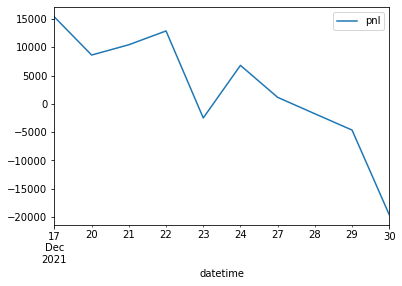

In [91]:
df.set_index('datetime').cumsum().plot()#[datetime(2022,1,1):].cumsum()#.plot()# [datetime(2022,1,1):]